In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu)

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
    
    if(True): # This does atomics - very slow
        C = tf.zeros([N, K])
        i, j, k = tf.indices([N, K, M])
        tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
    else: # This does a loop - much faster
        C = tf.buffer([N, K])
        i, j = C.indices
        s = tf.zeros([N, K], tf.float32)
        def loop_body(k):
            s.set(s + A[i, k] * Bt[j, k])
        tf.loop(loop_body, 0, M, 1)
        C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
matmul:
  Kernel count: 3
  Intermediate buffers: 1
  Lines of generated code: 364



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 8.023412   8.511229   8.414188  ... 10.286224   9.289123   9.630704 ]
 [ 5.8582234  5.660045   6.7205853 ...  7.5588813  6.6141195  7.045857 ]
 [ 6.2377524  7.482339   6.4836564 ...  8.657501   7.374624   7.794066 ]
 ...
 [ 6.2619133  5.5766883  6.1817403 ...  7.9574904  6.847672   7.575783 ]
 [ 7.487477   7.996026   8.716254  ...  7.484413   7.364576   9.19152  ]
 [ 5.6187267  7.0685244  7.032706  ...  8.669703   7.5862985  7.939471 ]]
[[ 8.023413   8.511228   8.414188  ... 10.286225   9.289124   9.630704 ]
 [ 5.858222   5.660046   6.720586  ...  7.5588818  6.6141195  7.0458574]
 [ 6.2377534  7.48234    6.483656  ...  8.657501   7.3746223  7.794066 ]
 ...
 [ 6.2619123  5.576688   6.1817408 ...  7.95749    6.8476715  7.5757823]
 [ 7.4874754  7.996026   8.716255  ...  7.4844112  7.3645763  9.191519 ]
 [ 5.6187267  7.0685244  7.032707  ...  8.669704   7.586299   7.9394712]]
Error: 6.726722e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.001034185435187607
TensorFrost:  0.04570567117978449
TF/NP:  44.194850966445124


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

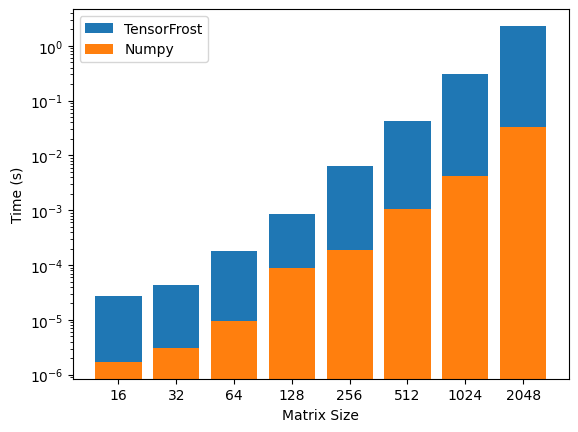

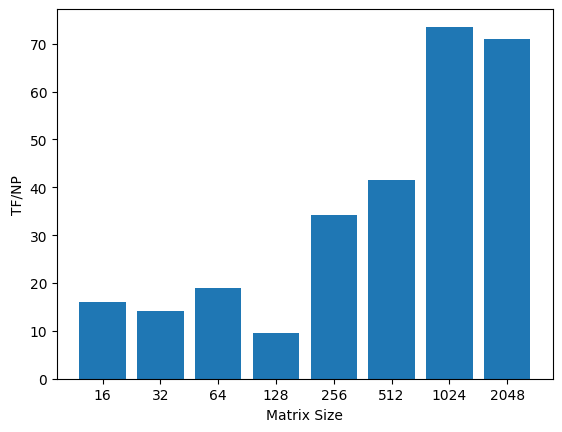

[2.7263352678753026e-05, 4.284574378351247e-05, 0.00017703022577066337, 0.0008519034978681366, 0.006522068729648342, 0.04309843977292379, 0.3098248839378357, 2.3082547187805176]
[1.7075050325538492e-06, 3.042140888443592e-06, 9.36535143818996e-06, 9.013961944566333e-05, 0.00019061767525799185, 0.001037096853700944, 0.004213030598744625, 0.03249253765229256]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)